In [132]:
import pandas as pd
import numpy as np
import tensorflow as tf
from Evaluation import get_metrics
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## Read Data

In [2]:
from Data_prep import leave_last_out

In [3]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'
# path = '../'

In [4]:
# data_path = 'Data/Amazon/'
# file_name = 'am_20k_users'
# file_name = 'am_like_ml'

data_path = 'Data/ML/'
file_name = 'ml_1m'

In [5]:
df = pd.read_pickle(path + data_path + file_name)
total_items = df.item_id.nunique()
total_users = df.user_id.nunique()

In [6]:
# MF based Data
train_set_mf = pd.read_pickle(path + data_path + file_name + '_train_mf')
val_set_mf = pd.read_pickle(path + data_path + file_name + '_val_mf')
test_set_mf = pd.read_pickle(path + data_path + file_name + '_test_mf')

In [12]:
# Eval
steps = 5
rank_at = 20
n_runs = 30

## Top 5 GS results

In [10]:
pd.read_pickle(path + 'Logs/GS/' + file_name + '_bpr_gs_log').sort_values('test_rec@10', ascending=False).iloc[:5]

,val_rec@10,learning_rate,train_loss,val_auc,p,q,train_time,total_test_rec,test_rec@10,nolf,n_iterations,sample_size,seed,alpha,rho,sigma,reg_user,reg_item,file
5,"[0.014, 0.04, 0.04, 0.05, 0.048, 0.048, 0.042,...","[0.03, 0.033, 0.036300000000000006, 0.03993000...","[0.6928840096669814, 0.6885358726376268, 0.611...",[],0,0,305.445064,0.328,0.078,8,25,299612.7,1234,0.03,1.1,0.5,0,0,ml_1m
41,"[0.046, 0.046, 0.054, 0.048, 0.048, 0.058, 0.0...","[0.08, 0.08800000000000001, 0.0968000000000000...","[0.6681123964756175, 0.3958474435381411, 0.310...",[],0,0,297.027570,0.352,0.077,8,25,299612.7,1234,0.08,1.1,0.5,0.001,0.001,ml_1m
45,"[0.046, 0.046, 0.06, 0.056, 0.052, 0.054, 0.06...","[0.1, 0.11000000000000001, 0.12100000000000002...","[0.6242018303224871, 0.3482956618510598, 0.293...",[],0,0,271.964864,0.345,0.076,8,25,299612.7,1234,0.10,1.1,0.5,0.001,0.001,ml_1m
37,"[0.028, 0.046, 0.052, 0.046, 0.048, 0.046, 0.0...","[0.05, 0.05500000000000001, 0.0605000000000000...","[0.6919734206500515, 0.5955196889772099, 0.377...",[],0,0,298.123402,0.342,0.075,8,25,299612.7,1234,0.05,1.1,0.5,0.001,0.001,ml_1m
1,"[0.01, 0.01, 0.012, 0.016, 0.03, 0.036, 0.046,...","[0.01, 0.011000000000000001, 0.012100000000000...","[0.6932482913189884, 0.6927994985776338, 0.692...",[],0,0,312.357428,0.325,0.073,8,25,299612.7,1234,0.01,1.1,0.5,0,0,ml_1m


---
# BPR
- ML: Final run for GS iloc 41

In [13]:
sample_size = 0.3

In [18]:
bpr_params = {
"nolf": 8, #Size of latent feature vectors
"n_iterations": 25, #around 20 is sufficient
"sample_size": sample_size*len(train_set_mf),
"seed": 0,
"alpha": 0.08, # Learning rate: Amazon_01 best: 0.08
"rho": 1.05, # Bold driver increase alpha
"sigma": 0.55, # Bold driver decrease alpha
          
"reg_user": 0.001, # Am_40k best: 0.1 # ML_1 best: 0
"reg_item": 0.001, # Am_40k best: 0.1 # ML_1 best: 0
}

In [19]:
from BPR import BPR
for i in range(n_runs):
    bpr = BPR(total_users, total_items, bpr_params)
    samples_name = file_name + '_bpr_samples'
    sample_path = path + data_path + 'Samples/' + samples_name + '_' + str(sample_size) + '.npy'
    bpr.train_model(sample_path = sample_path, 
                    train_set=train_set_mf, 
                    val_set=val_set_mf,
                    verbose=1,
                    patience=10,
                    save_best=True)
    ranked_df_bpr = bpr.get_predictions(train_set_mf, test_set_mf, stats=False)
    bpr_metrics = get_metrics(ranked_df_bpr, steps, rank_at, stats=False)
    other_info = {'metrics':bpr_metrics, 'file_name':file_name}
    
    bpr.store_model(path + '/Logs/final/', file_name + '_bpr_log', other_info)

Training BPR on 2 samples of size 299612
iteration: 0  loss: 0.675711  val_rec@10: 0.046
iteration: 1  loss: 0.407643  val_rec@10: 0.054
new results created
Training BPR on 2 samples of size 299612
iteration: 0  loss: 0.668776  val_rec@10: 0.06
iteration: 1  loss: 0.396988  val_rec@10: 0.052
results added
Training BPR on 2 samples of size 299612
iteration: 0  loss: 0.654939  val_rec@10: 0.048
iteration: 1  loss: 0.383163  val_rec@10: 0.05
results added
Training BPR on 2 samples of size 299612
iteration: 0  loss: 0.666322  val_rec@10: 0.054
iteration: 1  loss: 0.3949  val_rec@10: 0.058
results added
Training BPR on 2 samples of size 299612
iteration: 0  loss: 0.670341  val_rec@10: 0.044
iteration: 1  loss: 0.396564  val_rec@10: 0.046
results added
Training BPR on 2 samples of size 299612
iteration: 0  loss: 0.662641  val_rec@10: 0.05
iteration: 1  loss: 0.38841  val_rec@10: 0.056
results added
Training BPR on 2 samples of size 299612
iteration: 0  loss: 0.665128  val_rec@10: 0.054
itera

KeyboardInterrupt: 

In [226]:
from Evaluation import get_final_results
res_path = path + '/Logs/final/' + file_name + '_bpr_log'
final_metrics, train_stats, train_time = get_final_results(res_path)

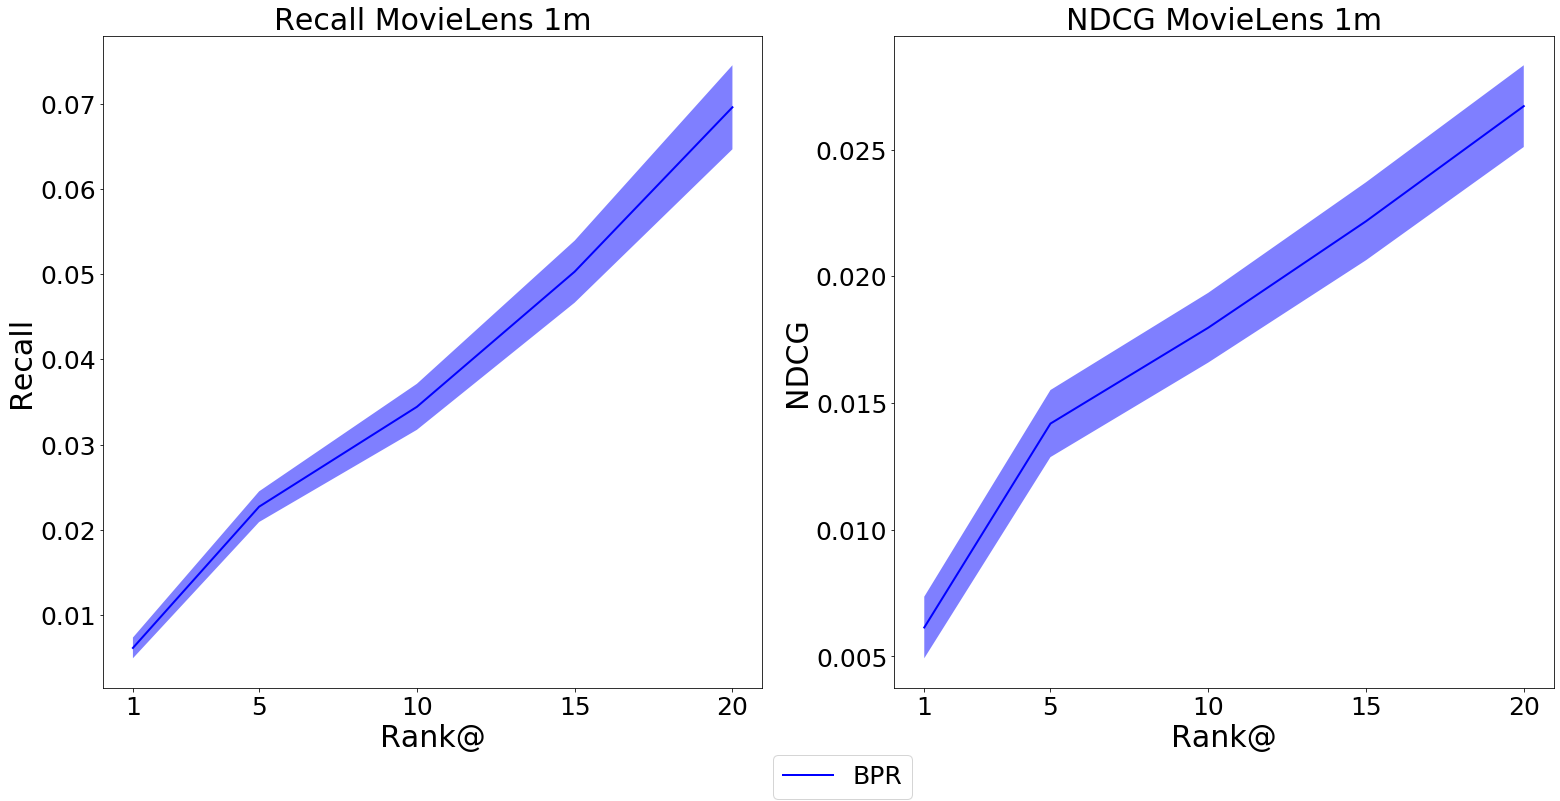

In [275]:
from visualize_results import plot_final_metrics
all_final_results = [final_metrics]
colors = ['blue']
labels = ['BPR']
metrics_to_show = ['recall', 'ndcg']
add_to_title = 'MovieLens 1m'
plot_final_metrics(all_final_results, colors, labels, metrics_to_show, add_to_title)